<h1 align="center">Quora Question Pair Similarity Challenge</h1>

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Quora_logo_2015.svg/250px-Quora_logo_2015.svg.png)


# Introduction to the problem

                        "Quora is a place to gain and share knowledge—about anything."
                        
It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

When this challenge was first posted on Kaggle, Quora used a Random Forest model to identify duplicate questions. In this competition, engineers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

In this notebook, I attempt to give a solution for the same. Now that we understand the end goal, let's begin this exciting journey by taking a peek at the data. Before that, let's import the libraries we require.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import distance
from sklearn.model_selection import train_test_split
import gensim
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import re
from bs4 import BeautifulSoup
from multiprocessing import Pool
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, log_loss, precision_score, recall_score
from prettytable import PrettyTable
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras.layers import Dropout
import tensorflow as tf
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

In [3]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

Load the data provided by Kaggle. I'll be working with the `train.csv` file only. The test dataset provided by Kaggle doesn't have ground Truth Labels so we wouldn't be actually able to *test* on it.

In [38]:
df_quora = pd.read_csv('train.csv')

There are 404290 rows in this data.

In [39]:
df_quora.shape

(404290, 6)

Are there any null values?

In [40]:
df_quora[df_quora.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


There are. Let's drop these data points.

In [41]:
df_quora.drop(df_quora[df_quora.isnull().any(axis=1)].index, inplace=True)

In [42]:
df_quora[df_quora.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [43]:
df_quora.shape

(404287, 6)

# Exploratory Data Analysis (EDA)

The data is arranged in the form of two question IDs per row and a `ground truth` label called **is_duplicate** which indicates whether the two questions are duplicates of each other.

In [44]:
df_quora.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate
99703,99703,165486,165487,What are the applications of linear algebra in...,What is the application of linear algebra to e...,0
266357,266357,383523,383524,My exam didn't go well and I can't focus on my...,My first exam didn't go so well and the though...,1
113941,113941,56652,47388,I am 15 years old and I have a long torso and ...,How can I shave my legs forever without surger...,0
223749,223749,331643,64491,What is the best carbohydrates supplement?,What are the best supplements?,0
122514,122514,198277,51533,What is the limit of (x^2+x)/(x+x) as x approa...,What is the limit of 1 as 2 approaches 3?,0
206992,206992,310556,310557,"Which bike should I choose between Gixxer SF ,...",Is it true that PMC's do a lot of terrible thi...,0
293096,293096,30223,42593,Which laptop is best under 25000 INR?,Which laptop is better for a enginnering stude...,1
330870,330870,457675,457676,Which is the best text book for engineering ma...,What is the best book for engineering mathemat...,1
370640,370640,112391,501204,Is lagertha alive?,Who is alive?,0
123213,123213,199268,199269,What is masturbation for girls especially Indi...,What are the bad behaviors of north Indians? E...,0


In [46]:
df_quora.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
id              404287 non-null int64
qid1            404287 non-null int64
qid2            404287 non-null int64
question1       404287 non-null object
question2       404287 non-null object
is_duplicate    404287 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


## Are the class labels balanced?

About 63% data points are not duplicates while the other 36% are duplicate questions.

In [47]:
df_quora.is_duplicate.value_counts(dropna=False) / df_quora.shape[0] * 100 

0    63.079941
1    36.920059
Name: is_duplicate, dtype: float64

## How many unique question pairs does this data have?

404287

In [48]:
df_quora.drop_duplicates(subset=['qid1', 'qid2']).shape

(404287, 6)

## How many unique questions does this data have?

In [49]:
len(set(df_quora.question1.tolist()) | set(df_quora.question2.tolist()))

537359

In [50]:
pd.concat([df_quora.question1, df_quora.question2]).nunique()

537359

## Frequency of questions

**Top 10 questions that occur most frequently in the dataset**

In [51]:
pd.concat([df_quora.question1, df_quora.question2]).value_counts().head(10)

What are the best ways to lose weight?                                                                161
How can you look at someone's private Instagram account without following them?                       120
How can I lose weight quickly?                                                                        111
What's the easiest way to make money online?                                                           88
Can you see who views your Instagram?                                                                  79
What are some things new employees should know going into their first day at AT&T?                     77
What do you think of the decision by the Indian Government to demonetize 500 and 1000 rupee notes?     68
Which is the best digital marketing course?                                                            66
How can you increase your height?                                                                      63
How do l see who viewed my videos on Instagram

**How many questions appear just once?**

In [52]:
(pd.concat([df_quora.question1, df_quora.question2], axis=0).value_counts() == 1).sum()

425489

Almost 80% of the questions are unique.

**Note**: This of course doesn't mean that 80% questions have different meanings. What it means is 80% questions have different wordings, while 20% questions have the exact same "strings".

In [53]:
425489/537359 * 100

79.18151552314188

**Visualizing the number of occurences of questions**

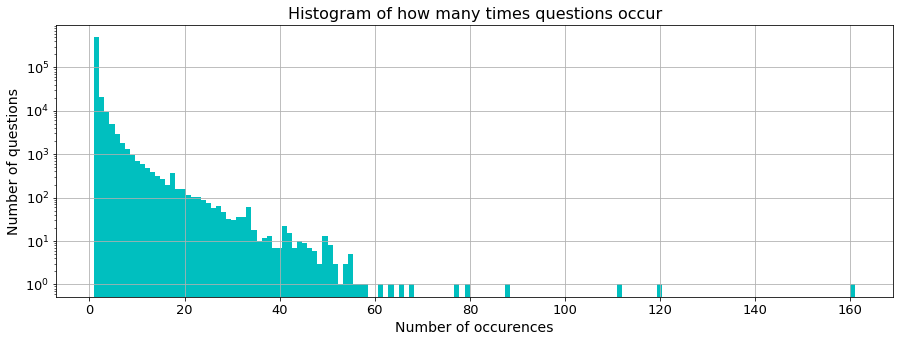

In [54]:
plt.figure(figsize=(15,5))
plt.hist(pd.concat([df_quora.question1, df_quora.question2], axis=0).value_counts(), bins=150, color='c')
plt.yscale('log')
plt.grid()
plt.title('Histogram of how many times questions occur', fontsize=16)
plt.xlabel('Number of occurences', fontsize=14)
plt.ylabel('Number of questions', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

# Data cleaning and preprocessing

There are non-alphanumeric characters & stopwords in the text data which essentially add little meaning to the question. Generally speaking, if you compare two questions, it is the keywords, nouns and non-stopwords in them which are sufficient to tell if the questions are duplicates of each other. To that end, it is necessary that we clean them beforehand.

In [55]:
# nltk.download('stopwords')
STOPWORDS = stopwords.words('english')

In [56]:
print(STOPWORDS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Define a function that does text preprocessing (cleaning).

In [57]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('[^a-zA-Z0-9_]')
    
    if type(x) is str:
        x = re.sub(pattern, ' ', x)
        x = porter.stem(x)
        x = re.sub('\s+',' ', x)
        
    x = ' '.join([w for w in x.split() if w not in STOPWORDS])
    
    return x

## Clean the questions

In [65]:
%%notify
df_quora['question1_cleaned'] = df_quora.question1.map(preprocess)
df_quora['question2_cleaned'] = df_quora.question2.map(preprocess)

<IPython.core.display.Javascript object>

In [66]:
df_quora.shape

(404287, 8)

**Examples of cleaned vs uncleaned questions**

In [67]:
print('Uncleaned:',df_quora.question1.loc[404278])
print('Cleaned:',df_quora.question1_cleaned.loc[404278])

Uncleaned: How did you prepare for AIIMS/NEET/AIPMT?
Cleaned: prepare aiims neet aipmt


In [68]:
print('Uncleaned:',df_quora.question1.loc[132726])
print('Cleaned:',df_quora.question1_cleaned.loc[132726])

Uncleaned: What is the difference between "Biotic" and "Abiotic"?
Cleaned: difference biotic abiotic


In [69]:
print('Uncleaned:',df_quora.question1.loc[204526])
print('Cleaned:',df_quora.question1_cleaned.loc[204526])

Uncleaned: What is the Script to buy Redmi 3s/Redmi 3s prime from a Flash Sale to be held on 14 September?
Cleaned: script buy redmi 3s redmi 3s prime flash sale held 14 september


In [70]:
print('Uncleaned:',df_quora.question1.loc[223518])
print('Cleaned:',df_quora.question1_cleaned.loc[223518])

Uncleaned: Can I get into XLRI PGDM - GM with a GMAT score of 660 and with a work ex of 6+ years?
Cleaned: get xlri pgdm gm gmat score 660 work ex 6 years


### Do the cleaned questions make sense?

Examples of duplicate questions

In [71]:
df_quora[df_quora.is_duplicate == 1][[
    'question1', 'question1_cleaned', 'question2', 'question2_cleaned'
]].sample(10)

,question1,question1_cleaned,question2,question2_cleaned
213222,How can I learn the basics of computer?,learn basics computer,How can I learn the basics of computers?,learn basics computers
187006,Do white guys date Asian girls?,white guys date asian girls,Why do white Western guys like Asian girls?,white western guys like asian girls
277322,How can you be a werewolf in real life?,werewolf real life,What are some ways to turn into a werewolf in ...,ways turn werewolf real life
266022,Why are you living your life?,living life,Why do you live a life?,live life
197897,How startups get funding?,startups get funding,How startup get funding?,startup get funding
25030,What is Linux? What is its use?,linux use,What is the use of Linux?,use linux
182705,Can Trump repeal laws that allow gay marriages?,trump repeal laws allow gay marriages,How easy would it be for Trump to overturn gay...,easy would trump overturn gay marriage
376995,Is Quora better than Google for answers?,quora better google answers,How is Quora better than Google?,quora better google
265113,Why have I never been taught about Nikola Tesl...,never taught nikola tesla highschool appear ph...,Why has Nikola Tesla been ignored in school ed...,nikola tesla ignored school education
364148,Which countries have nuclear weapons and where...,countries nuclear weapons,How many countries have nuclear weapons?,many countries nuclear weapons


### Do the cleaned questions make sense?

Examples of non-duplicate questions

In [72]:
df_quora[df_quora.is_duplicate == 0][[
    'question1', 'question1_cleaned', 'question2', 'question2_cleaned'
]].sample(10)

,question1,question1_cleaned,question2,question2_cleaned
181820,Is the mirror an accurate depiction of what yo...,mirror accurate depiction look like,Is a mirror reflection or photograph a more ac...,mirror reflection photograph accurate interpre...
301247,What is it like to wear revealing clothes in p...,like wear revealing clothes public,Do foreigners feel surprised to see some Indon...,foreigners feel surprised see indonesian women...
315380,What is the difference between an intelligent ...,difference intelligent person smart person,"What is the difference between intelligence, c...",difference intelligence cleverness smartness f...
129391,What's the difference between citalopram vs. x...,difference citalopram vs xanax,Can Citalopram be used to treat memory loss?,citalopram used treat memory loss
385625,Why is the new blue coloured Jio SIM package h...,new blue coloured jio sim package number printed,"Why is the line ""product also available withou...",line product also available without offer prin...
276710,How do the tourist attractions on the Scandina...,tourist attractions scandinavian highlands com...,How do the tourist attractions on the Scandina...,tourist attractions scandinavian highlands com...
83399,How is the word 'arid' used in a sentence?,word arid used sentence,"How is the word ""vivacious"" used in a sentence?",word vivacious used sentence
219792,What do guys really think about inexperienced ...,guys really think inexperienced women,"Do men like ""inexperienced"" women?",men like inexperienced women
374206,What is the best area to live in if I am worki...,best area live working cisco san jose,Who all got offers from Cisco San Jose from In...,got offers cisco san jose india
296819,I accidentally pushed a q-tip too far in my ea...,accidentally pushed q tip far ear pulled ear s...,How can I fix my ears that stick out?,fix ears stick


## Feature extraction
Obviously, we can't feed in the raw text in the questions to the ML models. They consume only numbers. Therefore, we need to somehow convert the raw text of the questions into numbers.

I'll use 4 types of features in this notebook.

    1. Basic features such as frequency and count of questions/words
    2. fuzzywuzzy features
    3. Tfidf weighted W2V embeddings using Google's pre-trained W2V model
    4. Only Tfidf features

### Basic features

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____n_word_common____ = (Number of common unique words in Question 1 and Question 2)
 - ____total_words____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(total_words)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

**1. question frequencies**

In [73]:
question_frequency_mapping = pd.concat(
    [df_quora.qid1, df_quora.qid2], axis=0).value_counts().to_dict()

In [74]:
df_quora['freq_qid1'] = df_quora['qid1'].map(question_frequency_mapping)
df_quora['freq_qid2'] = df_quora['qid2'].map(question_frequency_mapping)

**2. Length of the questions**

Here, we have two options. Should we consider length of the cleaned(preprocessed) questions or uncleaned questions? Note that the difference between the cleaned versions of the questions have more emphasis on the important words which give meaning to the question. In other words, they don't have stopwords.

Therefore, it makes sense to consider the question length after they've been preprocessed. Let's take this route. In the following sections, wherever needed I'll also compare how the features differ for cleaned vs uncleaned questions.

In [75]:
df_quora['question1_cleaned_len'] = df_quora['question1_cleaned'].str.len()
df_quora['question2_cleaned_len'] = df_quora['question2_cleaned'].str.len()

**Function to compare feature difference between Duplicate vs non-Duplicate questions**

In [76]:
def plot_dup_noDup_diff(z1, z2, g1_title, g2_title):

    def get_graph_text(z):
        mu = z.mean()
        median = np.median(z)
        sigma = z.std()
        textstr = '\n'.join(
            (r'$\mu=%.2f$' % (mu, ), r'$\mathrm{median}=%.2f$' % (median, ),
             r'$\sigma=%.2f$' % (sigma, )))

        return textstr
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)

    ax = sbn.distplot(z1, color='b')

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.4,
            0.75,
            get_graph_text(z1),
            transform=ax.transAxes,
            fontsize=18,
            verticalalignment='center',
            bbox=props)

    plt.title(g1_title, fontsize=16)

    plt.subplot(1, 2, 2)

    ax = sbn.distplot(z2, color='r')

    # place a text box in upper left in axes coords
    ax.text(0.4,
            0.75,
            get_graph_text(z2),
            transform=ax.transAxes,
            fontsize=18,
            verticalalignment='center',
            bbox=props)

    plt.title(g2_title, fontsize=16)

    plt.tight_layout()
    plt.show()

**Distribution of question lengths for duplicate and non-duplicate questions**

What you can see in the graph above is exciting! Clearly, there's some difference between how the difference between the question lengths is distributed for duplicate and non-Duplicate questions.

Duplicate questions tend to have similar lengths, while non-duplicates vary in lengths a lot. This feature might prove useful!

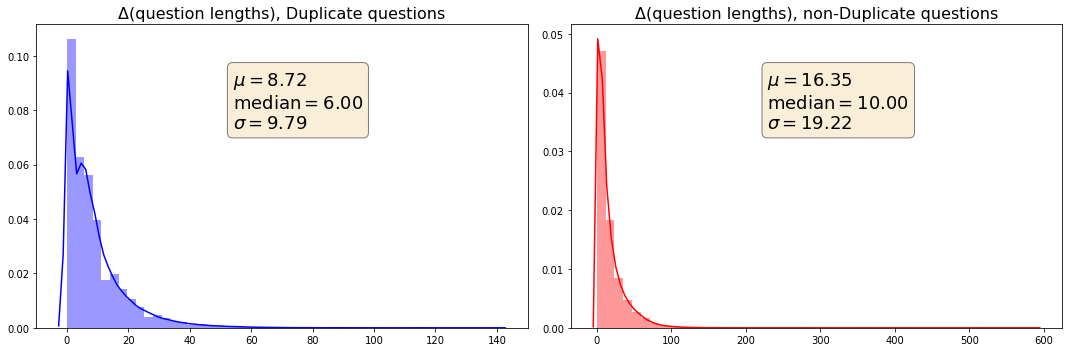

In [77]:
z1 = np.abs(df_quora[(df_quora.is_duplicate == 1)]['question1_cleaned_len'] -
           df_quora[(df_quora.is_duplicate == 1)]['question2_cleaned_len'])

z2 = np.abs(df_quora[(df_quora.is_duplicate == 0)]['question1_cleaned_len'] -
           df_quora[(df_quora.is_duplicate == 0)]['question2_cleaned_len'])


plot_dup_noDup_diff(z1, z2, 'Δ(question lengths), Duplicate questions', 'Δ(question lengths), non-Duplicate questions')

**3. Number of words in the question**

In [79]:
df_quora['q1_n_words'] = df_quora['question1_cleaned'].map(lambda x: len(x.split()))
df_quora['q2_n_words'] = df_quora['question2_cleaned'].map(lambda x: len(x.split()))

The following plot displays the difference between the number of words in questions which are duplicates and those which are not duplicates. Again, there's some clear distinction between the mean, median and std.

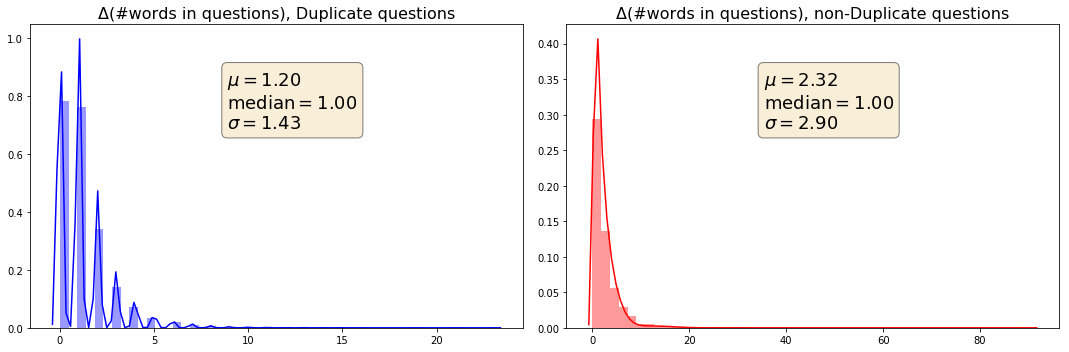

In [80]:
z1 = np.abs(df_quora[(df_quora.is_duplicate == 1)]['q1_n_words'] -
           df_quora[(df_quora.is_duplicate == 1)]['q2_n_words'])

z2 = np.abs(df_quora[(df_quora.is_duplicate == 0)]['q1_n_words'] -
           df_quora[(df_quora.is_duplicate == 0)]['q2_n_words'])


plot_dup_noDup_diff(z1, z2, 'Δ(#words in questions), Duplicate questions', 'Δ(#words in questions), non-Duplicate questions')

**4. Words common between question1 and question2**

In [81]:
df_quora[['question1_cleaned', 'question2_cleaned']].head(10)

,question1_cleaned,question2_cleaned
0,step step guide invest share market india,step step guide invest share market
1,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,increase speed internet connection using vpn,internet speed increased hacking dns
3,mentally lonely solve,find remainder math 23 24 math divided 24 23
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water
5,astrology capricorn sun cap moon cap rising say,triple capricorn sun moon ascendant capricorn say
6,buy tiago,keeps childern active far phone video games
7,good geologist,great geologist
8,use instead,use instead
9,motorola company hack charter motorolla dcx3400,hack motorola dcx3400 free internet


In [82]:
df_quora['n_word_common'] = df_quora.apply(lambda x: len(
    set(x['question1_cleaned'].split()).intersection(
        set(x['question2_cleaned'].split()))),
                                           axis=1)

Duplicate questions tend to have more common words between them on average, when compared with non-duplicate questions, which is to be expected.

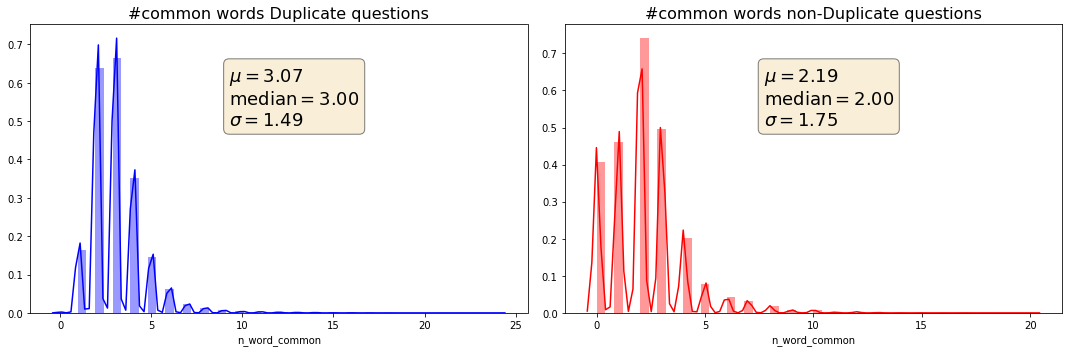

In [83]:
z1 = df_quora[(df_quora.is_duplicate == 1)]['n_word_common']
z2 = df_quora[(df_quora.is_duplicate == 0)]['n_word_common']

plot_dup_noDup_diff(z1, z2, '#common words Duplicate questions', '#common words non-Duplicate questions')

**5. Total words in question1 and question2**

In [85]:
df_quora['total_words'] = df_quora.apply(lambda x: len(x[
    'question1_cleaned'].split()) + len(x['question2_cleaned'].split()),
                                         axis=1)

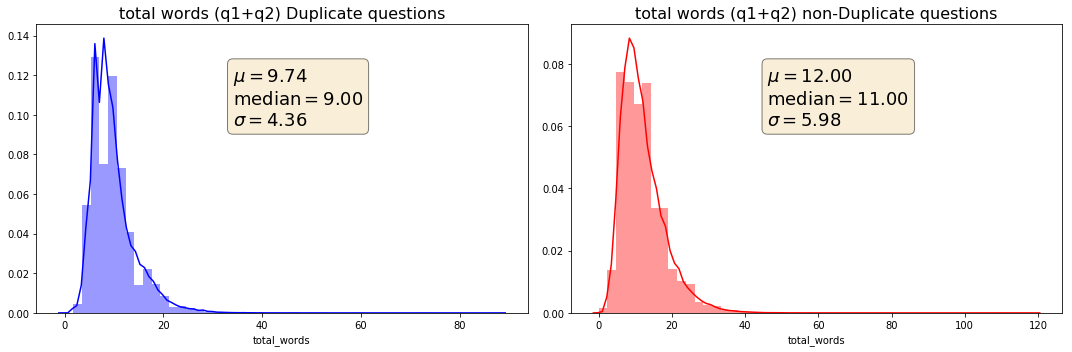

In [86]:
z1 = df_quora[(df_quora.is_duplicate == 1)]['total_words']
z2 = df_quora[(df_quora.is_duplicate == 0)]['total_words']

plot_dup_noDup_diff(z1, z2, 'total words (q1+q2) Duplicate questions',
                    'total words (q1+q2) non-Duplicate questions')

**6. word share**

In [87]:
df_quora.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,freq_qid1,freq_qid2,question1_cleaned_len,question2_cleaned_len,q1_n_words,q2_n_words,n_word_common,total_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guide invest share market india,step step guide invest share market,1,1,41,35,7,6,5,13


In [88]:
df_quora['word_share'] = df_quora['n_word_common'] / df_quora['total_words']

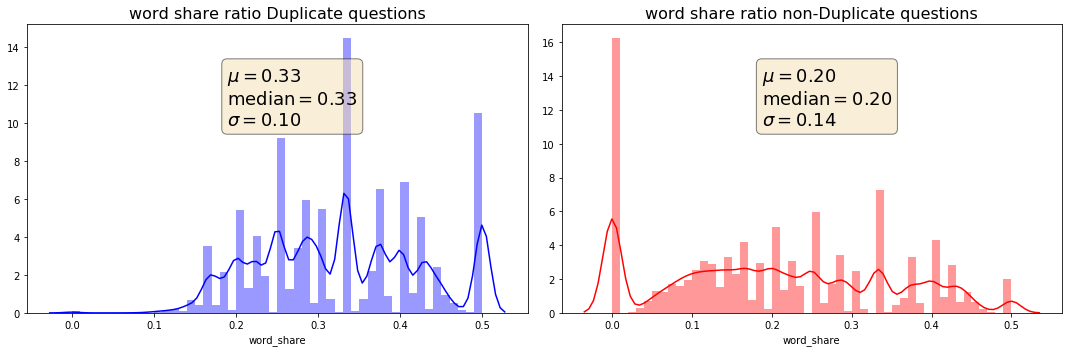

In [89]:
z1 = df_quora[(df_quora.is_duplicate == 1)
              & (df_quora.word_share.notnull())]['word_share']
z2 = df_quora[(df_quora.is_duplicate == 0)
              & (df_quora.word_share.notnull())]['word_share']

plot_dup_noDup_diff(z1, z2, 'word share ratio Duplicate questions',
                    'word share ratio non-Duplicate questions')

**7. Sum/difference of frequency**

In [90]:
df_quora.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'question1_cleaned', 'question2_cleaned', 'freq_qid1', 'freq_qid2',
       'question1_cleaned_len', 'question2_cleaned_len', 'q1_n_words',
       'q2_n_words', 'n_word_common', 'total_words', 'word_share'],
      dtype='object')

In [91]:
df_quora['freq_sum'] = df_quora['freq_qid1'] + df_quora['freq_qid2']
df_quora['freq_diff'] = np.abs(df_quora['freq_qid1'] - df_quora['freq_qid2'])

In [92]:
df_quora.shape

(404287, 19)

### word commonality, min, max

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min length of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max length of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>

* **n_words_diff**: Difference between the number of words in the questions

* **mean_n_words**: Mean number of words between the questions

<br>


**8. cwc_min, cwc_max**

In [93]:
df_quora.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'question1_cleaned', 'question2_cleaned', 'freq_qid1', 'freq_qid2',
       'question1_cleaned_len', 'question2_cleaned_len', 'q1_n_words',
       'q2_n_words', 'n_word_common', 'total_words', 'word_share', 'freq_sum',
       'freq_diff'],
      dtype='object')

In [94]:
df_quora['cwc_min'] = df_quora['n_word_common'] / df_quora[['q1_n_words', 'q2_n_words']].min(axis=1)
df_quora['cwc_max'] = df_quora['n_word_common'] / df_quora[['q1_n_words', 'q2_n_words']].max(axis=1)

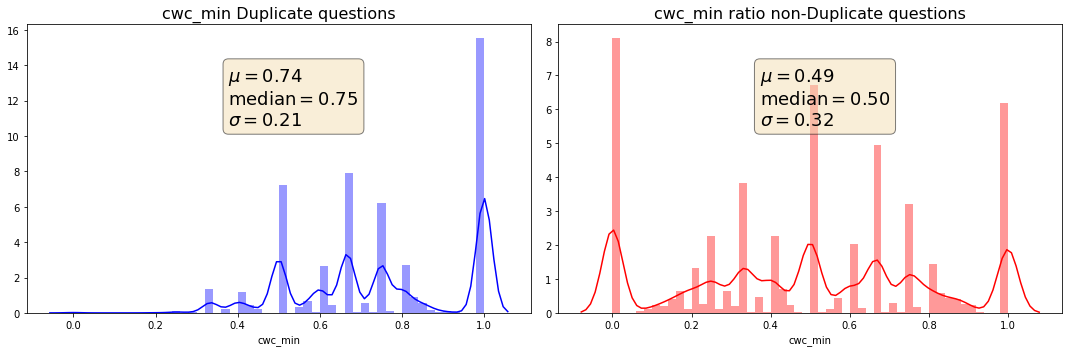

In [95]:
z1 = df_quora[(df_quora.is_duplicate == 1) & (df_quora.cwc_min.notnull())]['cwc_min']
z2 = df_quora[(df_quora.is_duplicate == 0) & (df_quora.cwc_min.notnull())]['cwc_min']

plot_dup_noDup_diff(z1, z2, 'cwc_min Duplicate questions', 'cwc_min ratio non-Duplicate questions')

**9. n_word_diff**

In [96]:
df_quora['n_word_diff'] = np.abs(df_quora['q1_n_words'] - df_quora['q2_n_words'])

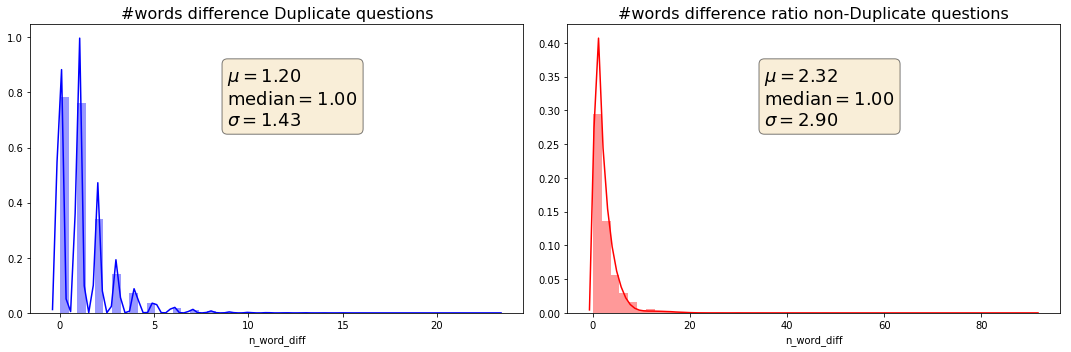

In [97]:
z1 = df_quora[(df_quora.is_duplicate == 1) & (df_quora.n_word_diff.notnull())]['n_word_diff']
z2 = df_quora[(df_quora.is_duplicate == 0) & (df_quora.n_word_diff.notnull())]['n_word_diff']

plot_dup_noDup_diff(z1, z2, '#words difference Duplicate questions', '#words difference ratio non-Duplicate questions')

**10. mean_n_words**

In [98]:
df_quora['mean_n_words'] = (df_quora['q1_n_words'] + df_quora['q2_n_words'])/2

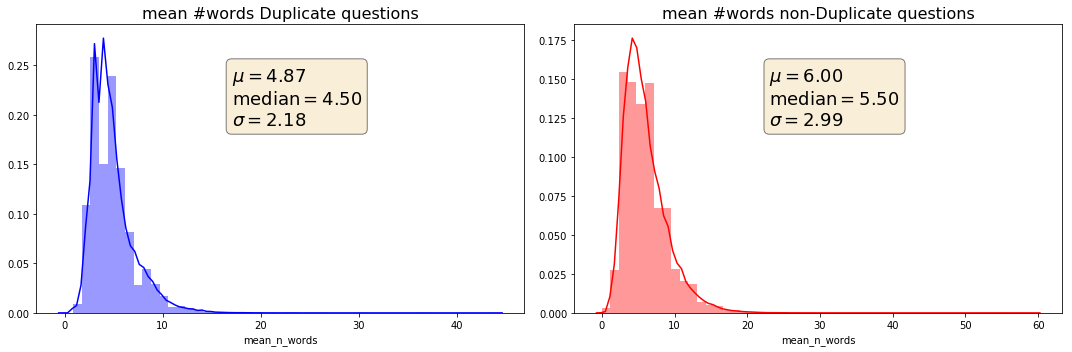

In [99]:
z1 = df_quora[(df_quora.is_duplicate == 1) ]['mean_n_words']
z2 = df_quora[(df_quora.is_duplicate == 0) ]['mean_n_words']

plot_dup_noDup_diff(z1, z2, 'mean #words Duplicate questions', 'mean #words non-Duplicate questions')

### Fuzzywuzzy features

the fuzzy functions available in the fuzzywuzzy library use the Lavenshtein distance to calculate the match between two strings. This distance counts how many substitutions are needed, given a string `u`, to transform it into `v`.

A substitution is defined as:

Erasing a character.
Adding one.
Replacing a character with another one.
The minimum amount of these operations that need to be done to u in order to turn it into v, correspond to the Levenshtein distance between those two strings.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/4520f5376b54613a5b0e6c6db46083989f901821)

Where i and j are indexes to the last character of the substring we’ll be comparing. The second term in the last expression is equal to 1 if those characters are different, and 0 if they’re the same.

This is the measure Python’s FuzzyWuzzy library uses.

**fuzz ratio**

the Levenshtein distance is at most the length of the longest string: replace all characters in the shorter one with the first part of the longer one, and then add the remaining ones. In order to return a ratio, we can normalize the distance, by dividing it by the longest string’s length. Otherwise, the number would fluctuate enormously as we give it inputs with different sizes.

**11. fuzz ratio**

In [101]:
df_quora['fr_cleaned'] = df_quora.apply(lambda x: fuzz.ratio(
    x['question1_cleaned'], x['question2_cleaned']),
                                        axis=1)

df_quora['fr_not_cleaned'] = df_quora.apply(lambda x: fuzz.ratio(
    x['question1'], x['question2']),
                                            axis=1)

Let's observe how the fuzz ratio is distributed for cleaned and uncleaned questions. Whichever distribution has maximum separation between duplicates and non-duplicates, we'll keep that version of the feature.

**NOTE**: The correlation coeffiecient between the fuzz ratio for cleaned and non-cleaned questions is high

In [102]:
df_quora[['fr_cleaned', 'fr_not_cleaned']].corr().loc['fr_cleaned', 'fr_not_cleaned']

0.9128027851884128

Fuzz ratio on cleaned questions

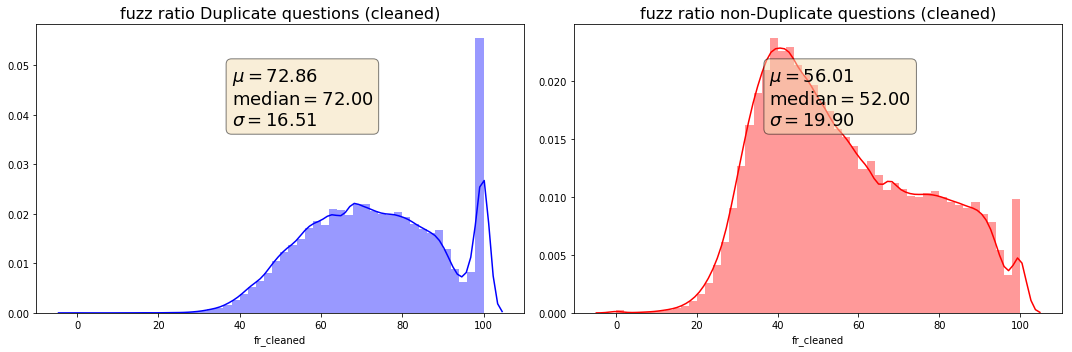

In [103]:
z1 = df_quora[(df_quora.is_duplicate == 1)]['fr_cleaned']
z2 = df_quora[(df_quora.is_duplicate == 0)]['fr_cleaned']

plot_dup_noDup_diff(z1, z2, 'fuzz ratio Duplicate questions (cleaned)',
                    'fuzz ratio non-Duplicate questions (cleaned)')

Fuzz ratio on non-cleaned questions

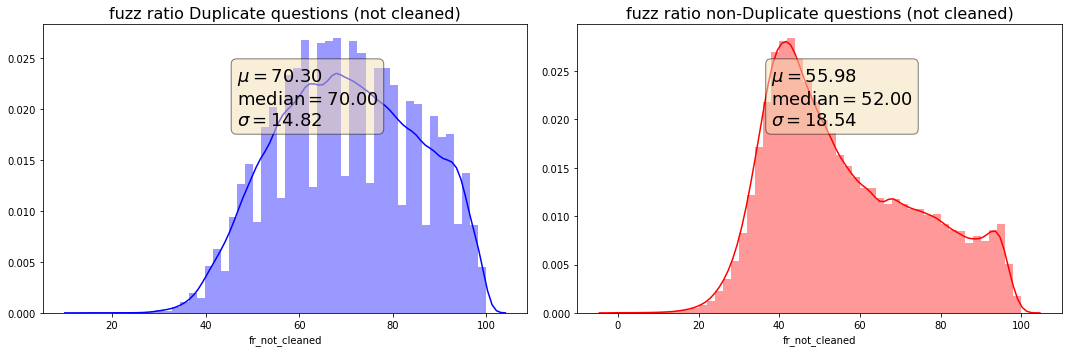

In [104]:
z1 = df_quora[(df_quora.is_duplicate == 1)]['fr_not_cleaned']
z2 = df_quora[(df_quora.is_duplicate == 0)]['fr_not_cleaned']

plot_dup_noDup_diff(z1, z2, 'fuzz ratio Duplicate questions (not cleaned)',
                    'fuzz ratio non-Duplicate questions (not cleaned)')

**12. fuzz partial ratio**

The partial_ratio method calculates the FuzzyWuzzy ratio for all substrings of the longer string with the length of the shorter one, and then returns the highest match.

In [106]:
df_quora['fpr_cleaned'] = df_quora.apply(lambda x: fuzz.partial_ratio(
    x['question1_cleaned'], x['question2_cleaned']),
                                        axis=1)

df_quora['fpr_not_cleaned'] = df_quora.apply(lambda x: fuzz.partial_ratio(
    x['question1'], x['question2']),
                                            axis=1)

In [107]:
df_quora[['fpr_cleaned', 'fpr_not_cleaned']].corr()

,fpr_cleaned,fpr_not_cleaned
fpr_cleaned,1.000000,0.857319
fpr_not_cleaned,0.857319,1.000000


Fuzz partial ratio on cleaned questions

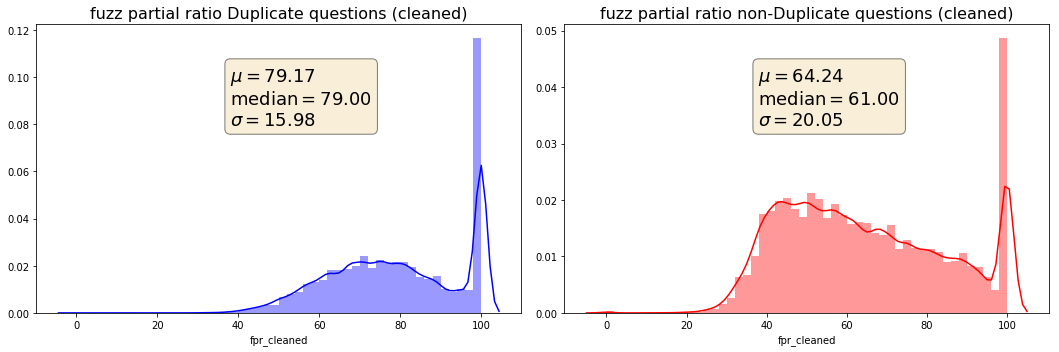

In [108]:
z1 = df_quora[(df_quora.is_duplicate == 1)]['fpr_cleaned']
z2 = df_quora[(df_quora.is_duplicate == 0)]['fpr_cleaned']

plot_dup_noDup_diff(z1, z2, 'fuzz partial ratio Duplicate questions (cleaned)',
                    'fuzz partial ratio non-Duplicate questions (cleaned)')

Fuzz partial ratio on non-cleaned questions

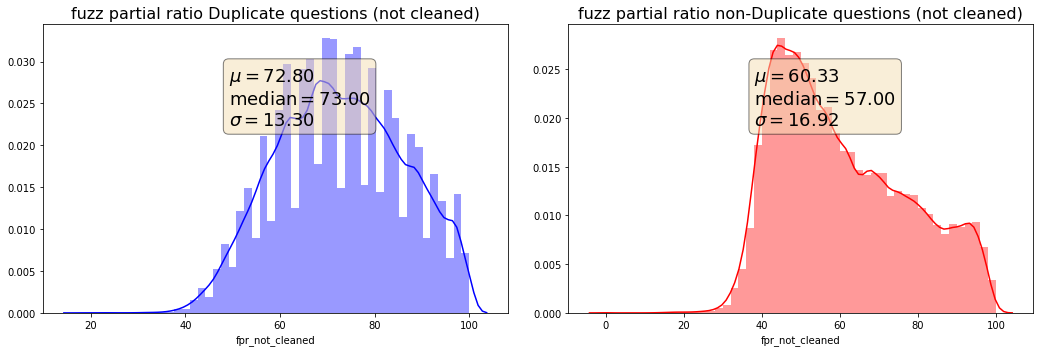

In [109]:
z1 = df_quora[(df_quora.is_duplicate == 1)]['fpr_not_cleaned']
z2 = df_quora[(df_quora.is_duplicate == 0)]['fpr_not_cleaned']

plot_dup_noDup_diff(z1, z2, 'fuzz partial ratio Duplicate questions (not cleaned)',
                    'fuzz partial ratio non-Duplicate questions (not cleaned)')

**13. Token sort ratio**

The Token Sort Ratio divides both strings into words, then joins those again alphanumerically, before calling the regular ratio on them.

In [110]:
%%notify
df_quora['tsr_cleaned'] = df_quora.apply(lambda x: fuzz.token_sort_ratio(
    x['question1_cleaned'], x['question2_cleaned']),
                                        axis=1)

df_quora['tsr_not_cleaned'] = df_quora.apply(lambda x: fuzz.token_sort_ratio(
    x['question1'], x['question2']),
                                            axis=1)

<IPython.core.display.Javascript object>

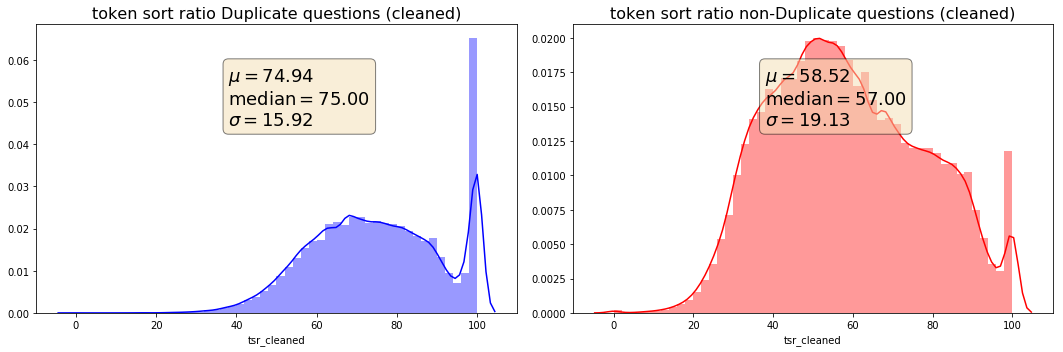

In [111]:
z1 = df_quora[(df_quora.is_duplicate == 1)]['tsr_cleaned']
z2 = df_quora[(df_quora.is_duplicate == 0)]['tsr_cleaned']

plot_dup_noDup_diff(z1, z2, 'token sort ratio Duplicate questions (cleaned)',
                    'token sort ratio non-Duplicate questions (cleaned)')

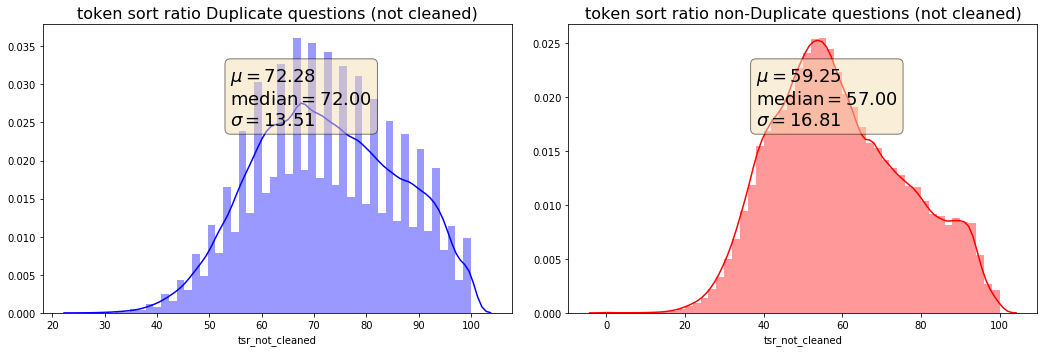

In [112]:
z1 = df_quora[(df_quora.is_duplicate == 1)]['tsr_not_cleaned']
z2 = df_quora[(df_quora.is_duplicate == 0)]['tsr_not_cleaned']

plot_dup_noDup_diff(z1, z2, 'token sort ratio Duplicate questions (not cleaned)',
                    'token sort ratio non-Duplicate questions (not cleaned)')

**14. Token SET ratio**

The Token Sort Ratio divides both strings into words, then joins those again alphanumerically, before calling the regular ratio on them.

In [113]:
%%notify
df_quora['tsetr_cleaned'] = df_quora.apply(lambda x: fuzz.token_set_ratio(
    x['question1_cleaned'], x['question2_cleaned']),
                                        axis=1)

df_quora['tsetr_not_cleaned'] = df_quora.apply(lambda x: fuzz.token_set_ratio(
    x['question1'], x['question2']),
                                            axis=1)

<IPython.core.display.Javascript object>

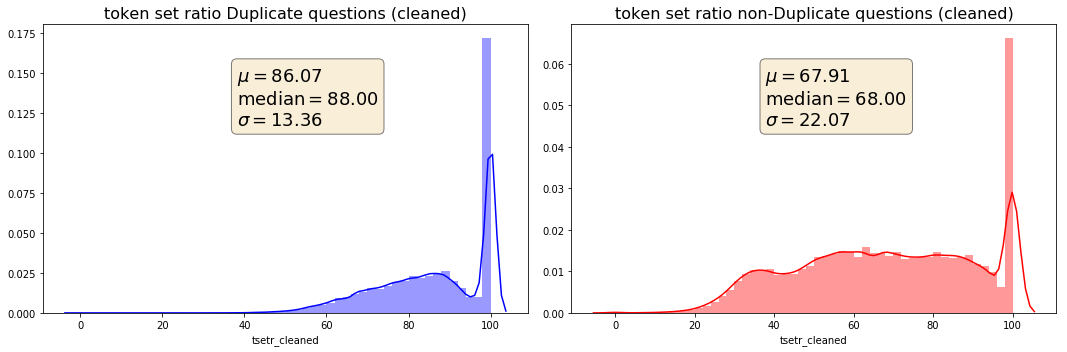

In [114]:
z1 = df_quora[(df_quora.is_duplicate == 1)]['tsetr_cleaned']
z2 = df_quora[(df_quora.is_duplicate == 0)]['tsetr_cleaned']

plot_dup_noDup_diff(z1, z2, 'token set ratio Duplicate questions (cleaned)',
                    'token set ratio non-Duplicate questions (cleaned)')

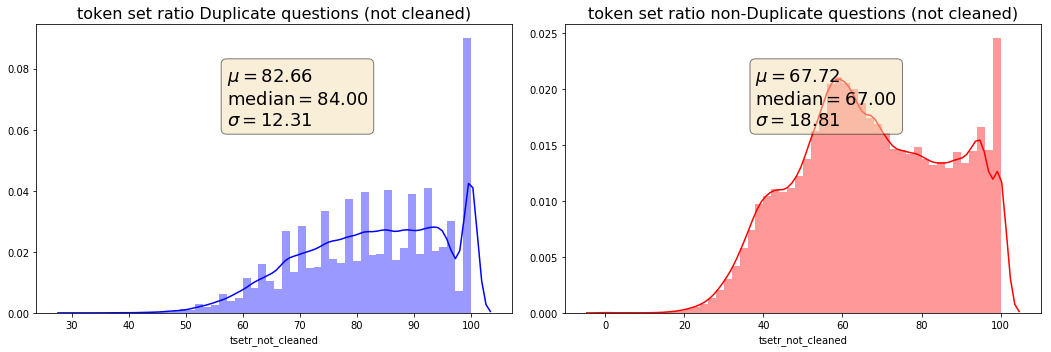

In [115]:
z1 = df_quora[(df_quora.is_duplicate == 1)]['tsetr_not_cleaned']
z2 = df_quora[(df_quora.is_duplicate == 0)]['tsetr_not_cleaned']

plot_dup_noDup_diff(z1, z2, 'token set ratio Duplicate questions (not cleaned)',
                    'token set ratio non-Duplicate questions (not cleaned)')

**15. Longest substring ratio**

In [116]:
# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [117]:
df_quora['longest_substr_ratio_cleaned'] = df_quora.apply(
    lambda x: get_longest_substr_ratio(x['question1_cleaned'], x[
        'question2_cleaned']),
    axis=1)

df_quora['longest_substr_ratio_not_cleaned'] = df_quora.apply(
    lambda x: get_longest_substr_ratio(x['question1'], x['question2']), axis=1)

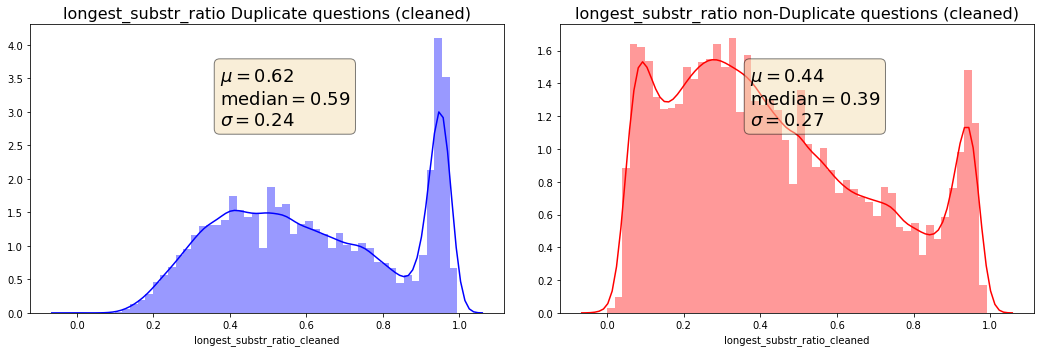

In [118]:
z1 = df_quora[(df_quora.is_duplicate == 1)]['longest_substr_ratio_cleaned']
z2 = df_quora[(df_quora.is_duplicate == 0)]['longest_substr_ratio_cleaned']

plot_dup_noDup_diff(z1, z2, 'longest_substr_ratio Duplicate questions (cleaned)',
                    'longest_substr_ratio non-Duplicate questions (cleaned)')

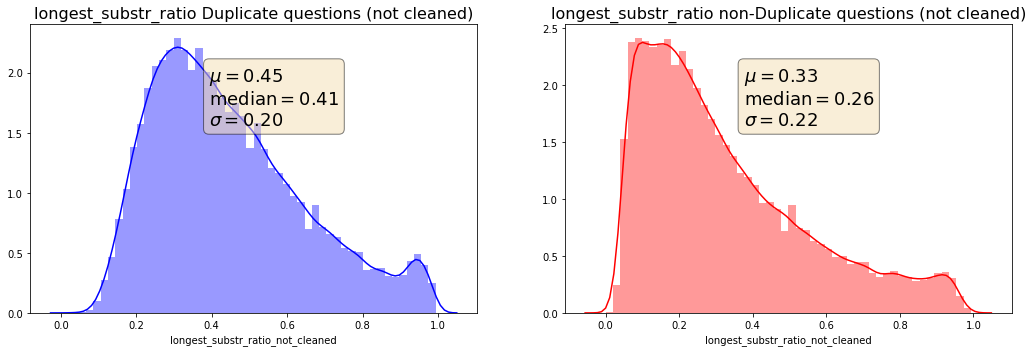

In [119]:
z1 = df_quora[(df_quora.is_duplicate == 1)]['longest_substr_ratio_not_cleaned']
z2 = df_quora[(df_quora.is_duplicate == 0)]['longest_substr_ratio_not_cleaned']

plot_dup_noDup_diff(z1, z2, 'longest_substr_ratio Duplicate questions (not cleaned)',
                    'longest_substr_ratio non-Duplicate questions (not cleaned)')

In [123]:
df_quora = df_quora[(df_quora.question1_cleaned.notnull()) & (df_quora.question2_cleaned.notnull())]

In [124]:
df_quora.to_csv('df_quora_ratio.csv', index=False)

**This is the dataframe after obtaining basic and fuzzy features**

In [128]:
df_quora.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,freq_qid1,freq_qid2,...,fr_cleaned,fr_not_cleaned,fpr_cleaned,fpr_not_cleaned,tsr_cleaned,tsr_not_cleaned,tsetr_cleaned,tsetr_not_cleaned,longest_substr_ratio_cleaned,longest_substr_ratio_not_cleaned
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guide invest share market india,step step guide invest share market,1,1,...,92,93,100,98,92,93,100,100,0.972222,0.965517
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,4,2,...,59,65,94,73,59,63,89,86,0.812500,0.442308
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increase speed internet connection using vpn,internet speed increased hacking dns,1,1,...,55,55,56,53,70,66,70,66,0.243243,0.150000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mentally lonely solve,find remainder math 23 24 math divided 24 23,1,1,...,22,28,24,30,22,36,22,36,0.045455,0.039216
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolve water quikly sugar salt methane c...,fish would survive salt water,3,1,...,43,45,52,54,40,47,51,67,0.200000,0.150000


### Word embedding features

Word embeddings is a powerful technique in which words are represented as vectors in n-dimensions. Furthermore, words with similar meaning are also geometrically closer in space.

We will use the Tfidf weighted W2V features for this problem.

In [130]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(list(df_quora['question1_cleaned']) + list(df_quora['question2_cleaned']))
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [131]:
len(tfidf.get_feature_names())

85662

In [23]:
tfidf.transform(df_quora['question1_cleaned'])

<404148x85643 sparse matrix of type '<class 'numpy.float64'>'
	with 2149637 stored elements in Compressed Sparse Row format>

**Load Google's pretrained W2V model**

I'm going to use the pretrained W2V model from Google trained on Google News, instead of training a W2V model from scratch myself on the questions data.

In [132]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

**Function to get the Tfidf weighted question embedding**

In [140]:
def get_question_embedding(df, column='question2_cleaned'):
    
    stacked_questions_vector = np.zeros((1,300))
    N = df.shape[0]
    
    for ix, row in df.iterrows():
        idf_weighted_w2v = np.zeros((1,300))
        idf_sum = 0
        
        for word in row[column].split():
            try:
                w2v = w2v_model.get_vector(word).reshape(1,300)
                idf = word2tfidf[word]
    
                idf_weighted_w2v += w2v*idf
                idf_sum += idf
            except:
                continue
        
        idf_weighted_w2v /= idf_sum

        stacked_questions_vector = np.vstack([stacked_questions_vector, idf_weighted_w2v])
        
        # print( np.round((ix/N)*100, 2), end='\r')
        
    return pd.DataFrame(stacked_questions_vector).drop(0, axis=0)

**Using multiprocessing to utilize multiple CPU cores to process faster**

In [ ]:
%%notify

p = Pool(processes=24)
data = p.map(get_question_embedding, np.array_split(df_quora, 24))
p.close()        

The above block of code returns 24 dataframes for 24 different processes as expected

In [142]:
len(data)

24

Combine the dataframes together to obtain the full Tfidf-weighted word embeddings.

In [136]:
df_q1_embedding = pd.DataFrame()

for df in data:
    df_q1_embedding=pd.concat([df_q1_embedding, df], axis=0, ignore_index=True)

This is how the question1 corpus looks when converted to tfidf weightd-W2V

In [137]:
df_q1_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.108278,0.018850,-0.023760,-0.068674,-0.066272,-0.019440,0.067927,-0.164302,0.064811,0.055734,...,-0.150996,0.166263,-0.070356,-0.071387,-0.066273,-0.004964,0.034808,0.092768,0.049434,-0.029453
1,-0.138217,0.119859,0.054456,0.052279,0.027710,0.030802,0.101644,-0.066964,-0.069299,0.058661,...,0.011496,-0.018092,-0.066042,-0.035540,0.066659,-0.127011,0.014579,-0.087963,0.069360,0.104727
2,0.057433,-0.005506,0.059876,0.023241,-0.083686,0.112702,-0.068044,-0.058281,0.190875,0.125190,...,0.042819,-0.002576,-0.077905,-0.002260,-0.021849,-0.096913,0.000780,-0.033107,-0.153849,-0.074187
3,-0.028208,0.059496,-0.217491,0.170921,-0.110902,0.233065,0.050290,0.071306,0.046443,-0.014304,...,-0.097384,0.250018,-0.201168,-0.009173,-0.218578,0.090617,-0.187513,-0.127825,-0.020533,0.021416
4,-0.109683,0.011323,0.100273,0.018661,-0.117877,-0.013659,-0.000475,-0.205814,0.046331,0.176704,...,-0.169694,-0.106100,-0.128757,0.049722,-0.076699,0.073173,-0.004342,0.057390,0.115352,-0.040542


In [138]:
df_q1_embedding.shape

(404287, 300)

In [139]:
df_q1_embedding.to_csv('df_q1_embedding.csv', index=False)

Similarly, obtain the question2 w2v embeddings

In [143]:
df_q2_embedding = pd.DataFrame()

for df in data:
    df_q2_embedding=pd.concat([df_q2_embedding, df], axis=0, ignore_index=True)

In [144]:
df_q2_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.096593,0.027248,-0.026941,-0.105263,-0.066576,-0.004681,0.071280,-0.142786,0.086562,0.064179,...,-0.161911,0.153074,-0.080042,-0.076306,-0.065401,-0.011532,0.051969,0.110187,0.064783,-0.021776
1,-0.079800,0.103979,0.044583,0.096845,-0.044173,-0.104413,0.018187,-0.091348,0.002249,0.088831,...,0.028503,0.042033,-0.052949,0.006518,0.039577,-0.046117,-0.023843,-0.090454,0.067170,0.012316
2,-0.010791,-0.006428,-0.072446,0.008972,-0.103186,0.085534,-0.095259,-0.023465,0.153797,0.102994,...,0.089460,0.030532,-0.064656,0.017508,-0.018218,-0.125023,0.098053,-0.027639,-0.131406,-0.023374
3,0.150419,-0.025316,0.062162,0.114710,-0.053689,0.032042,0.051905,-0.120939,-0.012303,-0.072518,...,-0.096365,0.107010,-0.013367,-0.139986,0.033373,-0.060981,0.081307,-0.010199,0.184717,-0.111477
4,-0.061046,0.152381,0.020872,0.038670,-0.115490,0.148133,-0.053669,-0.052518,0.003516,0.148430,...,-0.237522,-0.177128,-0.115274,0.011866,0.034054,0.028909,-0.055530,0.052604,0.137766,-0.053873


In [145]:
df_q2_embedding.shape

(404287, 300)

In [146]:
df_q2_embedding.to_csv('df_q2_embedding.csv', index=False)

## Final feature selection

We'll use the following features for training the first set of ML models

      1) 20 basic, ratio and fuzzy features
    + 2) 300 Tfidf weighted W2V features for question1
    + 3) 300 Tfidf weighted W2V features for question2
    =======================================================
    = 620 features overall

In [66]:
%%notify
df_q1_embedding = pd.read_csv('df_q1_embedding.csv')
df_q2_embedding = pd.read_csv('df_q2_embedding.csv')

<IPython.core.display.Javascript object>

In [68]:
df_quora.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'question1_cleaned', 'question2_cleaned', 'freq_qid1', 'freq_qid2',
       'question1_cleaned_len', 'question2_cleaned_len', 'q1_n_words',
       'q2_n_words', 'n_word_common', 'total_words', 'word_share', 'freq_sum',
       'freq_diff', 'cwc_min', 'cwc_max', 'n_word_diff', 'mean_n_words',
       'fr_cleaned', 'fr_not_cleaned', 'fpr_cleaned', 'fpr_not_cleaned',
       'tsr_cleaned', 'tsr_not_cleaned', 'tsetr_cleaned', 'tsetr_not_cleaned',
       'longest_substr_ratio_cleaned', 'longest_substr_ratio_not_cleaned'],
      dtype='object')

In [154]:
#y = df_quora['is_duplicate']

df_quora_X_ratios = df_quora[[
     'is_duplicate','freq_qid1', 'freq_qid2', 'question1_cleaned_len',
    'question2_cleaned_len', 'q1_n_words', 'q2_n_words', 'n_word_common',
    'total_words', 'word_share', 'freq_sum', 'freq_diff', 'cwc_min', 'cwc_max',
    'n_word_diff', 'mean_n_words', 'fr_cleaned', 'fpr_cleaned', 'tsr_cleaned',
    'tsetr_cleaned', 'longest_substr_ratio_cleaned'
]]

In [165]:
df_quora_X_ratios.shape

(404287, 21)

In [162]:
df_q1_embedding.shape

(404287, 300)

In [163]:
df_q2_embedding.shape

(404287, 300)

**Combine all the features**

In [159]:
df_quora_final = pd.concat([df_quora_X_ratios, df_q1_embedding, df_q2_embedding], axis=1)

**Remove records having any NaN**

In [ ]:
df_quora_final_noNaN = df_quora_final[~df_quora_final.isnull().any(axis=1)]

In [171]:
df_quora_final_noNaN.to_csv('df_quora_final_noNaN.csv', index=False)

In [176]:
df_quora_final_noNaN.head()

,is_duplicate,freq_qid1,freq_qid2,question1_cleaned_len,question2_cleaned_len,q1_n_words,q2_n_words,n_word_common,total_words,word_share,...,290,291,292,293,294,295,296,297,298,299
0,0.0,1.0,1.0,41.0,35.0,7.0,6.0,5.0,13.0,0.384615,...,-0.161911,0.153074,-0.080042,-0.076306,-0.065401,-0.011532,0.051969,0.110187,0.064783,-0.021776
1,0.0,4.0,2.0,31.0,67.0,5.0,10.0,4.0,15.0,0.266667,...,0.028503,0.042033,-0.052949,0.006518,0.039577,-0.046117,-0.023843,-0.090454,0.067170,0.012316
2,0.0,1.0,1.0,44.0,36.0,6.0,5.0,2.0,11.0,0.181818,...,0.089460,0.030532,-0.064656,0.017508,-0.018218,-0.125023,0.098053,-0.027639,-0.131406,-0.023374
3,0.0,1.0,1.0,21.0,44.0,3.0,9.0,0.0,12.0,0.000000,...,-0.096365,0.107010,-0.013367,-0.139986,0.033373,-0.060981,0.081307,-0.010199,0.184717,-0.111477
4,0.0,3.0,1.0,60.0,29.0,10.0,5.0,2.0,15.0,0.133333,...,-0.237522,-0.177128,-0.115274,0.011866,0.034054,0.028909,-0.055530,0.052604,0.137766,-0.053873


In [3]:
df_quora_final_noNaN[df_quora_final_noNaN.isnull().any(axis=1)]

,is_duplicate,freq_qid1,freq_qid2,question1_cleaned_len,question2_cleaned_len,q1_n_words,q2_n_words,n_word_common,total_words,word_share,...,290.1,291.1,292.1,293.1,294.1,295.1,296.1,297.1,298.1,299.1


## Train and test data

Here, we'll obtain the train and test data sets

**Separate the target label and the independent features**

In [5]:
df_quora_final_noNaN = pd.read_csv('df_quora_final_noNaN.csv')

In [6]:
y = df_quora_final_noNaN['is_duplicate']
X = df_quora_final_noNaN.drop('is_duplicate', axis=1).values

In [7]:
X.shape, y.shape

((402976, 620), (402976,))

Obtain train and test sets

In [8]:
X_train_CV, X_test, y_train_CV, y_test = train_test_split(X, y, test_size=0.15)

### **Distribution of classes in Train and Test sets**

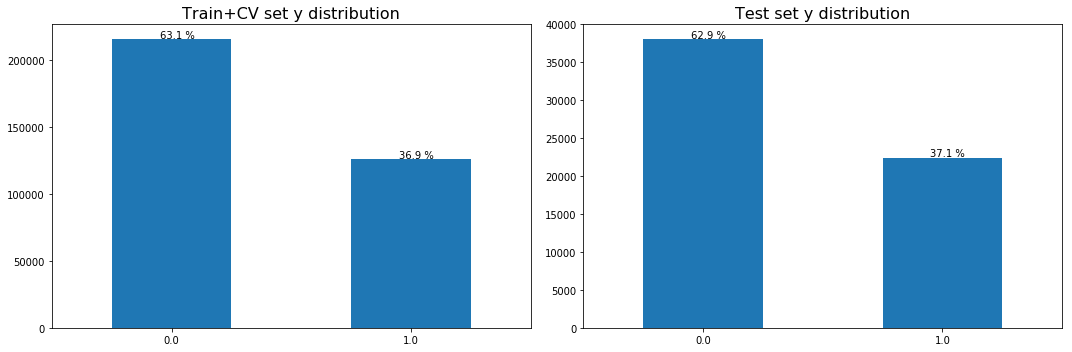

In [36]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax = y_train_CV.value_counts().plot.bar(rot=0)
total_data_points = X_train_CV.shape[0]

for p in ax.patches:
    ax.annotate('{:.1f} %'.format((p.get_height() / total_data_points) * 100),
                (p.get_x() + 0.2, p.get_height() + 150))

plt.title('Train+CV set y distribution', fontsize=16)
    
    
plt.subplot(1,2,2)
ax = y_test.value_counts(dropna=False).plot.bar(rot=0)
total_data_points = X_test.shape[0]

for p in ax.patches:
    ax.annotate('{:.1f} %'.format((p.get_height() / total_data_points) * 100),
                (p.get_x() + 0.2, p.get_height() + 150))

plt.title('Test set y distribution', fontsize=16)
    
plt.tight_layout()

In [9]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))

    labels = [1,2]
    # representing A in heatmap format
    cmap=sbn.light_palette("green")
    plt.subplot(1, 3, 1)
    sbn.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 20})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sbn.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 20})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sbn.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 20})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Standardize data

In [10]:
scaler = StandardScaler()
X_train_CV = scaler.fit_transform(X_train_CV)
X_test = scaler.transform(X_test)

### **Function to display model performance**

**Diclaimer**: Kindly ignore the "%" sign printed against the Log Loss in the bar graph displayed by this function. Initially, I was printing accuracy for each model. I later changed it to log loss and forgot to remove the % sign.

In [11]:
def show_model_performance(clf, X_test, y_test, param1_name = 'param_C', param2_name = None):
    
    if param1_name != 'mlp':
        print('*'*45, 'Model Summary', '*'*45)
        print('The best parameters were', clf.best_params_)
        print('The best Log loss during Training/CV was', clf.best_score_)
        print('Log loss score on Test data', clf.score(X_test, y_test))
        print('Precision:', np.round(precision_score(y_test, clf.predict(X_test)), 2))
        print('Recall:', np.round(recall_score(y_test, clf.predict(X_test)), 2))
        print('*' * 110)

    else:
        print('*'*45, 'Model Summary', '*'*45)
        print('The Log loss during last epoch was', clf.history.history['loss'][-1])
        print('Log loss score on Test data', clf.evaluate(X_test, y_test)[0])
        print('Precision:', np.round(precision_score(y_test, clf.predict_classes(X_test)), 2))
        print('Recall:', np.round(recall_score(y_test, clf.predict_classes(X_test)), 2))
    
    if param1_name != 'mlp':
        tn, fp, fn, tp  = confusion_matrix(y_test, clf.predict(X_test)).ravel()
    else:
        tn, fp, fn, tp  = confusion_matrix(y_test, clf.predict_classes(X_test)).ravel()
    
    if param1_name != 'mlp':
        plt.figure(figsize=(15, 6))

        plt.subplot(1,2,1)

        ax1 = sbn.barplot(list(clf_gridsrch.cv_results_[param1_name]), list(clf_gridsrch.cv_results_['mean_test_score']))
        #plt.gca().invert_yaxis()


        if param1_name == 'param_C' or param1_name == 'param_n_estimators':
            ax1.invert_yaxis()

        plt.title('Log Loss for various Hyper-parameters', fontsize=16)

        for p in ax1.patches:
            ax1.annotate('{:.4f} %'.format((p.get_height())),
                        (p.get_x() + 0.1, p.get_height() - 0.004), fontsize=14)

        #plt.show()

        plt.subplot(1,2,2)

    if param1_name != 'mlp':
        fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test).max(axis=1))
    else:
        fpr, tpr, thresholds = roc_curve(y_test, clf.predict(X_test))
    
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.title('Receiver Operating Characteristic Curve')
    ax = plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.show()

    print('*' * 45, 'Confusion Matrix', '*'*45)
    if param1_name != 'mlp':
        
        plot_confusion_matrix(y_test, clf.predict(X_test))
    else:
        
        plot_confusion_matrix(y_test, clf.predict_classes(X_test))
        
    plt.tight_layout()
    plt.show()
    
    print('*' * 110)

# Machine Learning Models

## Model 1: Logistic Regression (Basic + fuzzy + Tfidf-w2v features)

In [43]:
%%notify

lr = LogisticRegression(penalty='l1')

parameters_dict = {'C': [0.0001, 0.001, 0.01, 0.1, 1]}

clf_gridsrch = GridSearchCV(lr,
                            param_grid=parameters_dict,
                            n_jobs=12,
                            verbose=True,
                            cv=5,
                           scoring='neg_log_loss',
                           )

<IPython.core.display.Javascript object>

In [44]:
%%notify
clf_gridsrch.fit(X_train_CV,y_train_CV)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  25 out of  25 | elapsed: 63.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=12,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=True)

<IPython.core.display.Javascript object>

********************************************* Model Summary *********************************************
The best parameters were {'C': 0.01}
The best Log loss during Training/CV was -0.39696521222067416
Log loss score on Test data -0.3990039709158115
Precision: 0.78
Recall: 0.67
**************************************************************************************************************


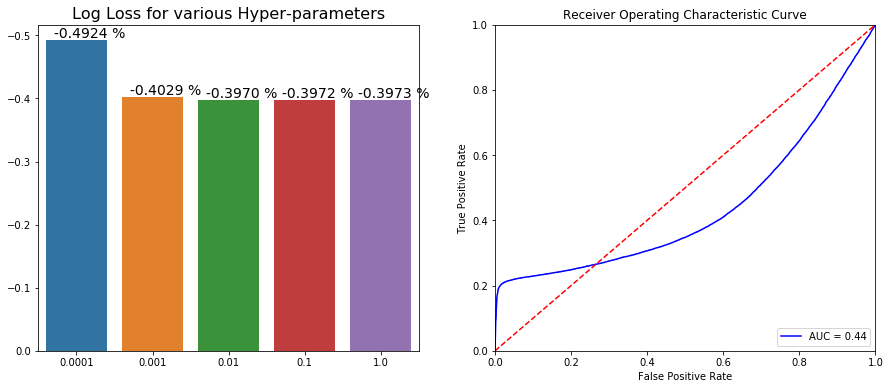

********************************************* Confusion Matrix *********************************************


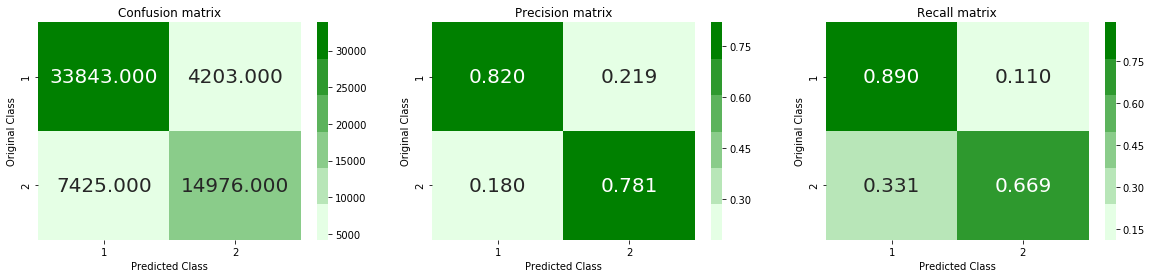

<Figure size 432x288 with 0 Axes>

**************************************************************************************************************


In [45]:
show_model_performance(clf_gridsrch, X_test, y_test, param1_name = 'param_C')

In [18]:
table = PrettyTable()
table.field_names = ['#', 'Model', 'Features', '#Features', 'Precision', 'Recall', 'Log loss', 'AUC']
table.add_row(['1', 'Logistic Regression', 'Ratios,\nW2V Embeddings', '620', '0.78', '0.67', '0.39', '0.44'])
table.add_row(['\n', '\n','\n','\n','\n','\n','\n', '\n'])

## Model 2: Linear SVC (Basic + fuzzy + Tfidf-w2v features)

In [221]:
svc = LinearSVC()
clf = CalibratedClassifierCV(svc)
parameters_dict = {'base_estimator__C': [0.01, 0.1 ,1, 10]}

clf_gridsrch = GridSearchCV(clf,
                            param_grid=parameters_dict,
                            n_jobs=-1,
                            verbose=1,
                            cv=3,
                           scoring='neg_log_loss')

In [222]:
%%notify
clf_gridsrch.fit(X_train_CV,y_train_CV)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed: 28.1min remaining: 20.1min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 28.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0,
                                                                       class_weight=None,
                                                                       dual=True,
                                                                       fit_intercept=True,
                                                                       intercept_scaling=1,
                                                                       loss='squared_hinge',
                                                                       max_iter=1000,
                                                                       multi_class='ovr',
                                                                       penalty='l2',
                                                                       random_state=None,
                                                                       

<IPython.core.display.Javascript object>

********************************************* Model Summary *********************************************
The best parameters were {'base_estimator__C': 0.01}
The best Log loss during Training/CV was 0.8057974653241039
Log loss score on Test data 0.8082121527950105
Precision: 0.79
Recall: 0.65
**************************************************************************************************************


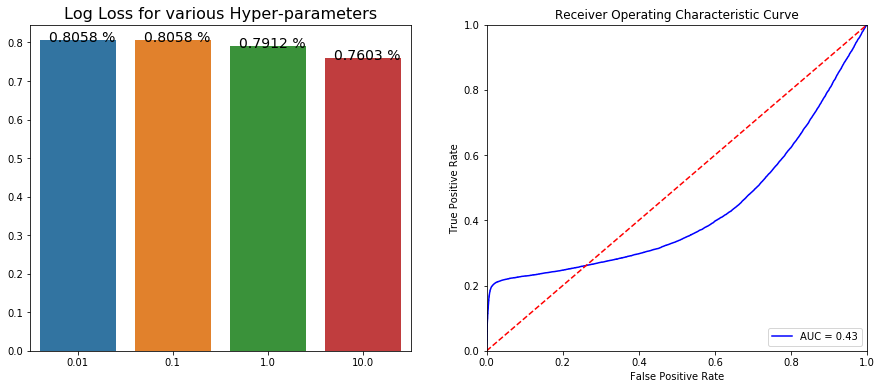

********************************************* Confusion Matrix *********************************************


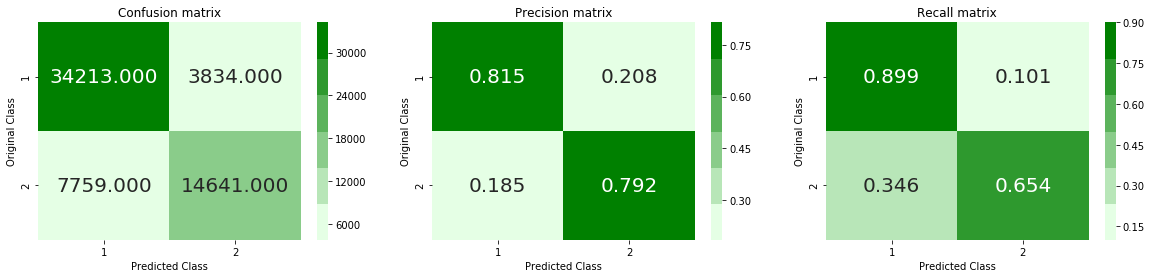

<Figure size 432x288 with 0 Axes>

**************************************************************************************************************


In [278]:
show_model_performance(clf_gridsrch, X_test, y_test, param1_name = 'param_base_estimator__C')

In [19]:
table.add_row(['2', 'Linear SVC', 'Ratios,\nW2V Embeddings', '620', '0.79', '0.65', '0.80', '0.43'])
table.add_row(['\n', '\n','\n','\n','\n','\n','\n', '\n'])

## Model 3: XGBoost (Basic + fuzzy + Tfidf-w2v features)

In [13]:
xgb = XGBClassifier()

parameters_dict = {'n_estimators' : [100,150,200]}

clf_gridsrch = GridSearchCV(xgb, param_grid=parameters_dict,
                           n_jobs=-1, verbose=1, cv=4, scoring='neg_log_loss')

In [14]:
%%notify
clf_gridsrch.fit(X_train_CV, y_train_CV)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed: 50.4min remaining: 36.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 62.4min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'n_estimators': [100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss

<IPython.core.display.Javascript object>

********************************************* Model Summary *********************************************
The best parameters were {'n_estimators': 200}
The best Log loss during Training/CV was -0.3404089569390926
Log loss score on Test data -0.3396784786249644
Precision: 0.81
Recall: 0.74
**************************************************************************************************************


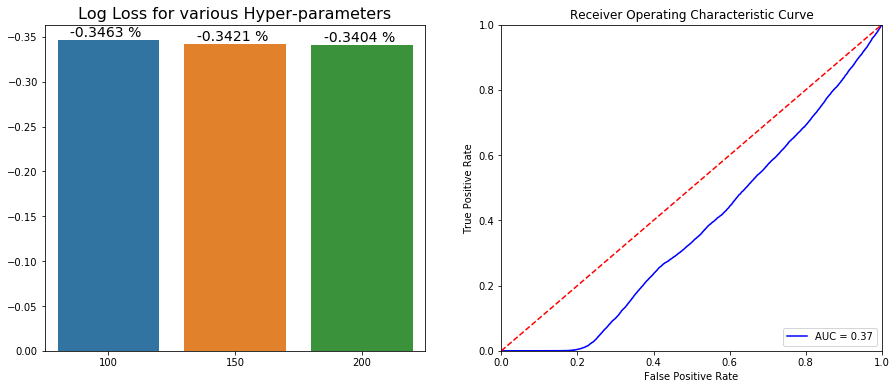

********************************************* Confusion Matrix *********************************************


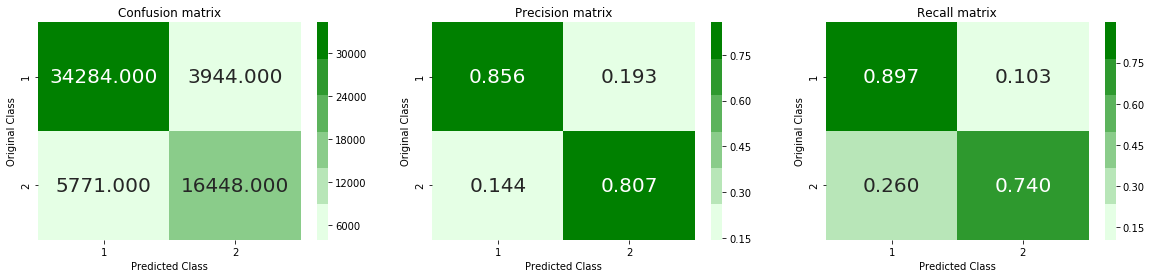

<Figure size 432x288 with 0 Axes>

**************************************************************************************************************


In [15]:
show_model_performance(clf_gridsrch, X_test, y_test, param1_name = 'param_n_estimators')

In [20]:
table.add_row(['3', 'XGBoost', 'Ratios,\nW2V Embeddings', '620', '0.81', '0.74', '0.33', '0.37'])
table.add_row(['\n', '\n','\n','\n','\n','\n','\n', '\n'])

## Model 4: Neural Network (MLP)

Now, let's build a simple Multi Layered Perceptron with a Sigmoid output function for this binary classification task. I'm using a server on GCP with a GPU attached to it. The following line of code confirms that Tensorflow can utilize the available GPU. 

In [4]:
tf.test.is_gpu_available()

True

In [231]:
X_train_CV.shape

(342529, 620)

In [234]:
model = models.Sequential()
model.add(
    layers.Dense(128,
                 activation='relu',
                 kernel_initializer='random_normal',
                 input_shape=(X_train_CV.shape[1], )))

model.add(layers.Dropout(.2))

model.add(layers.Dense(64, activation='relu', kernel_initializer='random_normal'))

model.add(layers.Dropout(.2))

model.add(layers.Dense(32, activation='relu'))

model.add(
    layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(
    X_train_CV,
    y_train_CV,
    epochs=100,
    batch_size=1024,
    verbose=1)

Epoch 1/100
342529/342529 [==============================] - 19s 56us/step - loss: 0.4788 - acc: 0.7328
Epoch 2/100
342529/342529 [==============================] - 11s 32us/step - loss: 0.4036 - acc: 0.7917
Epoch 3/100
342529/342529 [==============================] - 13s 38us/step - loss: 0.3838 - acc: 0.8084
Epoch 4/100
342529/342529 [==============================] - 11s 34us/step - loss: 0.3713 - acc: 0.8171
Epoch 5/100
342529/342529 [==============================] - 12s 35us/step - loss: 0.3627 - acc: 0.8232
Epoch 6/100
342529/342529 [==============================] - 13s 37us/step - loss: 0.3563 - acc: 0.8278
Epoch 7/100
342529/342529 [==============================] - 13s 37us/step - loss: 0.3507 - acc: 0.8316
Epoch 8/100
342529/342529 [==============================] - 13s 37us/step - loss: 0.3454 - acc: 0.8347
Epoch 9/100
342529/342529 [==============================] - 12s 35us/step - loss: 0.3411 - acc: 0.8381
Epoch 10/100
342529/342529 [==============================] - 11

********************************************* Model Summary *********************************************
The Log loss during last epoch was 0.24730752820755345
60447/60447 [==============================] - 5s 77us/step
Log loss score on Test data 0.4201803848477477
Precision: 0.75
Recall: 0.72


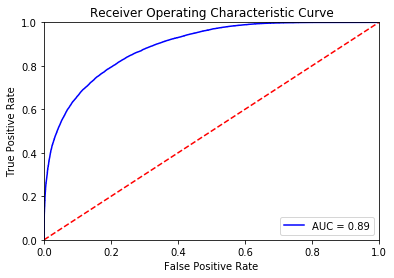

********************************************* Confusion Matrix *********************************************


<Figure size 1080x288 with 0 Axes>

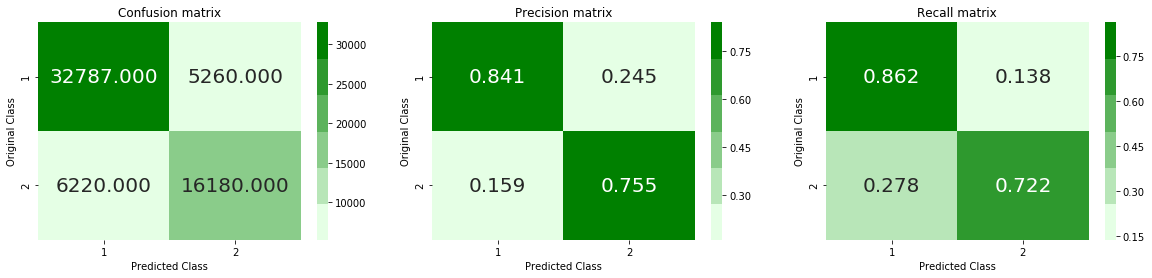

<Figure size 432x288 with 0 Axes>

**************************************************************************************************************


In [280]:
show_model_performance(model, X_test, y_test, param1_name = 'mlp')

In [22]:
table.add_row(['4', 'Neural Net\n[128-D/O-64-D/O-32-1]', 'Ratios,\nW2V Embeddings', '620', '0.75', '0.72', '0.42', '0.89'])
table.add_row(['\n', '\n','\n','\n','\n','\n','\n', '\n'])

# Only Tfidf features

Now, I'll consider only Tfidf features for classification. i.e. I'll not be using the W2V and other basic features used in the models so far.

In [5]:
df_quora = pd.read_csv('df_quora_ratio.csv')

In [6]:
df_quora.drop(df_quora[df_quora.isnull().any(axis=1)].index, inplace=True)

**Divide the data into train and test sets**

In [7]:
df_X_train_CV, df_X_test, y_train_CV, y_test = train_test_split(
    df_quora[['question1_cleaned', 'question2_cleaned']],
    df_quora['is_duplicate'],
    test_size=0.15)

In [8]:
df_X_train_CV.head()

,question1_cleaned,question2_cleaned
169076,famous pimps,apple become one famous computer companies
268654,best book learning language c,best books c
263014,invented silversmithing,silversmithing invented
133072,important thing life,important thing life money relations status
217852,umbro jerseys fit skinny people,umbro jerseys fit muscular people


**Fit the Tfidf model onto Train data**

Here, I'm considering maximum 8000 features to make it feasible to work with. If unconstrained, the number of features will go into tens of thousands.

In [9]:
tfidf = TfidfVectorizer(sublinear_tf=True, max_features=8000)

tf = tfidf.fit(
    pd.concat([
        df_X_train_CV['question1_cleaned'], df_X_train_CV['question2_cleaned']
    ],
              axis=0))

**Obtain the Tfidf train and test features**

In [10]:
X_train_CV = np.hstack([
    tf.transform(df_X_train_CV['question1_cleaned']).toarray(),
    tf.transform(df_X_train_CV['question2_cleaned']).toarray()
])

X_test = np.hstack([
    tf.transform(df_X_test['question1_cleaned']).toarray(),
    tf.transform(df_X_test['question2_cleaned']).toarray()
])


In [11]:
X_train_CV.shape

(343525, 16000)

## Model 5: Logistic Regression (Only Tfidf features)

In [12]:
%%notify

lr = LogisticRegression(penalty='l2', solver='lbfgs')

parameters_dict = {'C': [ 0.001, 0.01, 0.1, 1, 10]}

clf_gridsrch = GridSearchCV(lr,
                            param_grid=parameters_dict,
                            n_jobs=2,
                            verbose=True,
                            cv=3,
                           scoring='neg_log_loss',
                           )

<IPython.core.display.Javascript object>

In [13]:
%%notify
clf_gridsrch.fit(X_train_CV,y_train_CV)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 46.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=True)

<IPython.core.display.Javascript object>

********************************************* Model Summary *********************************************
The best parameters were {'C': 1}
The best Log loss during Training/CV was -0.5299274989778167
Log loss score on Test data -0.5224251929131951
Precision: 0.7
Recall: 0.53
**************************************************************************************************************


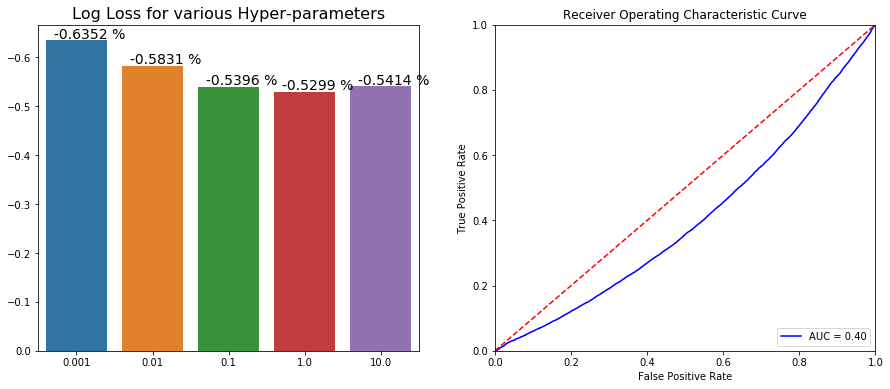

********************************************* Confusion Matrix *********************************************


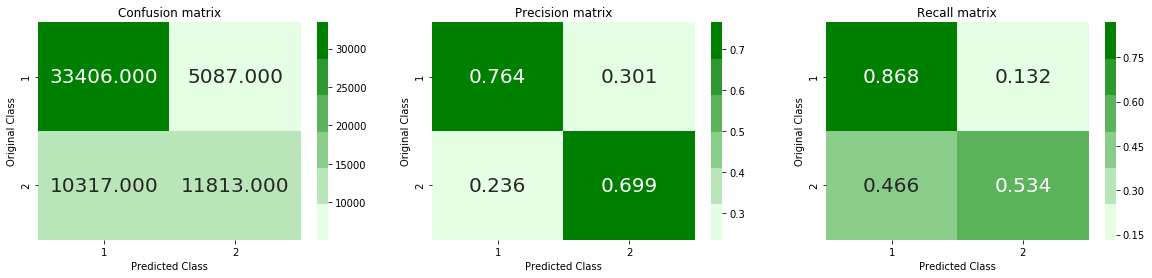

<Figure size 432x288 with 0 Axes>

**************************************************************************************************************


In [18]:
show_model_performance(clf_gridsrch, X_test, y_test, param1_name = 'param_C')

In [23]:
table.add_row(['5', 'Logistic Regression', 'TF-IDF', '16000', '0.70', '0.53', '0.52', '0.40'])
table.add_row(['\n', '\n','\n','\n','\n','\n','\n', '\n'])

## Model 6: Neural Net (Only Tfidf features)

In [26]:
model = models.Sequential()
model.add(
    layers.Dense(256,
                 activation='relu',
                 kernel_initializer='random_normal',
                 input_shape=(X_train_CV.shape[1], )))

model.add(layers.Dropout(.4))

model.add(layers.Dense(128, activation='relu', kernel_initializer='random_normal'))

model.add(layers.Dropout(.4))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dropout(.4))

model.add(layers.Dense(32, activation='relu'))

model.add(
    layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(
    X_train_CV,
    y_train_CV,
    epochs=30,
    batch_size=4096,
    verbose=1)

Epoch 1/30
343525/343525 [==============================] - 63s 183us/step - loss: 0.5693 - acc: 0.7105
Epoch 2/30
343525/343525 [==============================] - 63s 182us/step - loss: 0.4920 - acc: 0.7677
Epoch 3/30
343525/343525 [==============================] - 59s 171us/step - loss: 0.4547 - acc: 0.7901
Epoch 4/30
343525/343525 [==============================] - 54s 156us/step - loss: 0.4211 - acc: 0.8100
Epoch 5/30
343525/343525 [==============================] - 52s 151us/step - loss: 0.3889 - acc: 0.8286
Epoch 6/30
343525/343525 [==============================] - 54s 158us/step - loss: 0.3594 - acc: 0.8437
Epoch 7/30
343525/343525 [==============================] - 55s 159us/step - loss: 0.3304 - acc: 0.8586
Epoch 8/30
343525/343525 [==============================] - 57s 165us/step - loss: 0.3044 - acc: 0.8707
Epoch 9/30
343525/343525 [==============================] - 58s 170us/step - loss: 0.2807 - acc: 0.8814
Epoch 10/30
343525/343525 [==============================] - 60s

********************************************* Model Summary *********************************************
The Log loss during last epoch was 0.08385296626511676
60623/60623 [==============================] - 6s 98us/step
Log loss score on Test data 0.6750524845798632
Precision: 0.74
Recall: 0.73


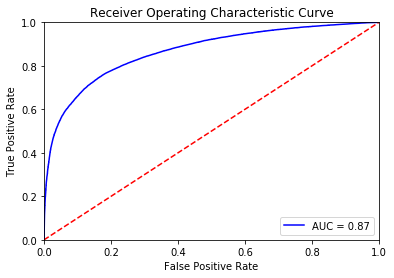

********************************************* Confusion Matrix *********************************************


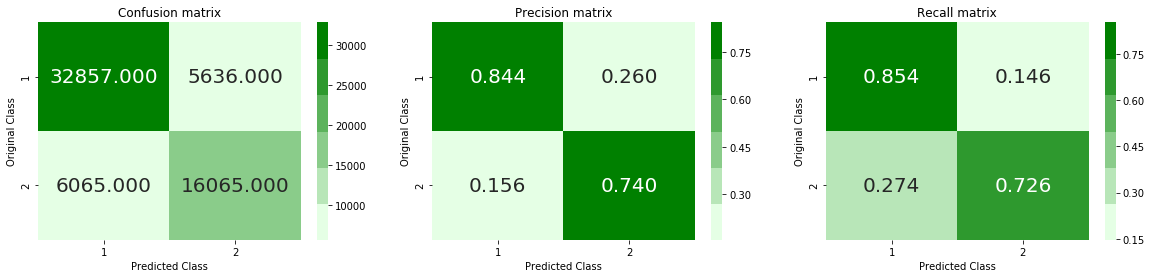

<Figure size 432x288 with 0 Axes>

**************************************************************************************************************


In [29]:
show_model_performance(model, X_test, y_test, param1_name = 'mlp')

In [24]:
table.add_row(['6', 'Neural Net\n[256-D/O-128-D/O-64-D/O-32-1]', 'TF-IDF', '16000', '0.74', '0.73', '0.67', '0.87'])

# Concluding Remarks

* In an attempt to come up with a solution for the question pairs classification challenge posted on Kaggle by Quora, we tried out 6 different models in this notebook.

* We started with basic feature engineering and also used advanced techniques such as W2V to featurize the questions which were provided in the original data as raw text.

* The best log loss obtained on test data was `0.33`, using the XGboost library. This model also gave the best `Recall` of `0.74`. A detailed summary of the models trained can be found below.

In [25]:
print(table)

+---+-------------------------------+----------------+-----------+-----------+--------+----------+------+
| # |             Model             |    Features    | #Features | Precision | Recall | Log loss | AUC  |
+---+-------------------------------+----------------+-----------+-----------+--------+----------+------+
| 1 |      Logistic Regression      |    Ratios,     |    620    |    0.78   |  0.67  |   0.39   | 0.44 |
|   |                               | W2V Embeddings |           |           |        |          |      |
|   |                               |                |           |           |        |          |      |
|   |                               |                |           |           |        |          |      |
| 2 |           Linear SVC          |    Ratios,     |    620    |    0.79   |  0.65  |   0.80   | 0.43 |
|   |                               | W2V Embeddings |           |           |        |          |      |
|   |                               |         